<a href="https://colab.research.google.com/github/zhangsushen1992/Test_functions/blob/master/Intro_To_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro to Deep Learning

This notebook accompanies the Intro to Deep Learning workshop run by Hackers at Cambridge

## Importing Data and Dependencies


First, we will import the dependencies - **numpy**, a python library we'll be using for matrix multplication, and **matplotlib** for visualisation purposes.

We'll import the datasets using nice loader functions from **sklearn**.


To run a cell, hover over the [    ] next to each cell and click the play button on the left - the number in the [   ]  tells you the order of execution (1, 2, 3 etc.)

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston,load_breast_cancer


We'll load the house dataset, using the **load_boston(return_X_y=True)** function. This returns our inputs $X$ and our labels $y$ as a tuple.
If you read them in, you'll notice they're not the right dimensions, so you'll need to reshape them. We have $m=506$ examples and $n=13$ features. 

We want to store $X$ in a $n$ x $m$ matrix (currently it is $m$ x $n$), and $y$ in a $1$ x $m$ matrix - currently it is a $m$ dimensional vector


It is also good practice to normalise the data: $\mu$ = mean, $\sigma$ = standard deviation *across examples*.

$$X = \frac{X-\mu}{\sigma}$$

as this speeds up learning.

Finally, split the data into training and test data sets - we'll keep the test data to the side to evaluate our model at the end.

### Useful functions:

          A.shape #return a tuple consisting of A's dimensions
          
          A = np.reshape(A, (b,c)) # reshapes A into a b x c matrix - (b,c) = tuple of dimensions
          A.T  #returns the transpose of A (flips rows and columns)
          
          np.mean(A, axis=1, keepdims=True) # takes the mean of A across axis 1 where axis 1 = columns, axis=0 is across rows. keepdims=True ensures number of dimensions is same 
          
                   
         np.std(A, axis=1, keepdims=True) #ditto but with standard deviation
       
       A[2:5, :] # we can take slices - e.g. this will return all the columns of the rows 2-4 




In [0]:
X,y = load_boston(return_X_y=True)

# reshape to make sure dimensions are right 

X = np.reshape(X,(13,506))
y = np.reshape(y,(1,506))

#normalise the data
X = (X-np.mean(X,axis=1,keepdims=True))/np.std(X,axis=1,keepdims=True)

#split data into train and test set
X_train = X[:,0:405]
Y_train = y[:,0:405]

X_test = X[:,405:506]
Y_test = y[:,405:506]


## Creating the neural network:

Having preprocessed our data into matrices, it is now time to create the feedforward neural network. 

First we need to initialise parameters: the weights and biases for each layer.

The weights for layer *$l$* are stored in *$ W^{(l)}$*, a *$n_l$ x $n_{(l-1)}$* matrix, where *$n_l$* is the number of units in layer *$l$*. 
We  initialise the weights randomly to break symmetry, and multiply by 0.001 to ensure weights aren't too large.

The biases for layer *$l$* are stored in *$ b^{(l)}$*, which is a *$n_l$ x 1* matrix.

### Useful functions:
          
          np.random.randn(a, b) # creates a random matrix with dimensions (a,b)
          np.zeros((a,b))  #matrix of zeros of size (a,b) - note the extra set of brackets!

In [0]:
def initialise_parameters(layers_units): #layers_units = list of number of nodes in each layer
    parameters = {}            # create a dictionary containing the parameters
    for l in range(1, len(layers_units)):
        parameters['W' + str(l)] = np.random.randn(layers_units[l],layers_units[l-1])*0.001
        parameters['b' + str(l)] = np.zeros((layers_units[l],1))
    return parameters

### Activation Functions:

The activation function $g(z)$ we will be using is the ReLU function $g(z) = max(0,z)$ in the hidden layers.

Another one is sigmoid : $\sigma(z) = \frac{1}{1 + e^{-z}}$

NB: Although the ReLU function is technically non-differentiable when $z=0$, in practice we can set the derivative=0 at $z=0$.


###Useful functions:
      
      np.exp(z) #exponentiates z element-wise
      A>c  #compares each element of A with c and because this is Python, False=0 , True=1 when multiplying with ints.
 
 So if you multiply this with matrix **A** , you can zero-out values where A>c is false.

In [0]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

def relu(z, deriv=False):
    if(deriv):  #This is for gradients - do this when you do next section!
        return z>0 #gradient = 1 if z>0, 0 otherwise
    else:
        return (z>0)*z

We can now write the code for the forward propagation step.

In each layer $l$ , we matrix multiply the output of the previous layer $A^{(l-1)}$  by a weight matrix $W^{(l)}$ and then add a bias term $b^{(l)}$. We then take the result $Z^{(l)}$ and apply the activation function $g(z)$ to it to get the output $A^{(l)}$. $L$ = number of layers.
The equations are thus:
$$Z^{(l)}=W^{(l)}A^{(l-1)}$$
$$A^{(l)}=g(Z^{(l)})$$
 
Here, we have $g(z) = ReLU(z)$

### Useful functions:
          
          C = A.dot(B) #matrix multiplies A, B
          C = np.dot(A,B) #equivalent operation
          
         



In [0]:
def forward_propagation(X,parameters):
    cache = {} #stores all our intermediate calculations since 
    L = len(parameters)//2 #final layer
    cache["A0"] = X #ease of notation since input = layer 0
    for l in range(1, L):
        cache['Z' + str(l)] = parameters['W' + str(l)].dot(cache['A'+str(l-1)])
        cache['A' + str(l)] = relu(cache['Z'+ str(l)]) #use relu as activation function
    #final layer
    cache['Z' + str(L)] = parameters['W'+str(L)].dot(cache['A'+str(L-1)])
    cache['A' + str(L)] = cache['Z' + str(L)] #no activation function for last layer 
    return cache 

## Implementing the Learning 


Next we can compute the loss function - this is the objective function the neural network will aim to minimise during training:

$m$ = number of training examples, $(x^{(i)},y^{(i)})$ is the $i^{th}$ training example.


**Mean Squared Error:**

$$ J(W^{(1)}, b^{(1)},...) = \frac{1}{2m} \sum_{i=1}^{m} (a^{(L) (i)} - y^{(i)})^2 $$

### Useful functions:
          
         np.square(A) #square each element in A

          np.sum(A, axis=1, keepdims= True) # just like mean and std, take sum along axis 1



In [0]:
def cost_function(AL,Y):
    m = 405
    cost = 1/(2*m)*np.sum(np.square(AL-Y))
    return cost

### Backpropagation:

Calculating the gradients:

$$\frac{\partial \mathcal{J} }{\partial Z^{(L)}} = A^{(L)} - Y$$ 


$$ \frac{\partial \mathcal{J} }{\partial W^{(l)}} = \frac{1}{m}\frac{\partial \mathcal{J} }{\partial Z^{(l)}} A^{(l-1) T} $$

$$ \frac{\partial \mathcal{J} }{\partial b^{(l)}} = \frac{1}{m} \sum_{i = 1}^{m} \frac{\partial \mathcal{J} }{\partial Z^{(l)(i)}}$$

$$ \frac{\partial \mathcal{J} }{\partial A^{(l-1)}} = W^{(l) T} \frac{\partial \mathcal{J} }{\partial Z^{(l)}} $$

$$ \frac{\partial \mathcal{J} }{\partial Z^{(l-1)}} = \frac{\partial \mathcal{J} }{\partial A^{(l-1)}}*g^{'}(Z^{(l-1)})$$


If you are keen, it's a good exercise to derive them yourself or alternatively check this [post](https://mukul-rathi.github.io/2018/08/31/Backpropagation.html) for a deeper dive into the intuition behind it.

### Useful functions:
          np.sum(A, axis=1, keepdims= True) # just like mean and std, take sum along axis 1
          
          A.dot(B) # matrix multiplication returns A.B
          
         A*B #returns elementwise multiplication (useful for last equation)
​
​

In [0]:
def backpropagation(cache,Y,parameters):
    L = len(parameters)//2 
    m = Y.shape[1]
    grads = {}
    #code up the last layer explicitly
    grads["dZ" + str(L)]= cache['A'+str(L)]-Y
    grads["dW" + str(L)]= (1/m)*grads["dZ"+str(L)].dot(cache['A'+str(L-1)].T)
    grads["db" + str(L)]= (1/m)*np.sum(grads["dZ"+str(L)],axis=1,keepdims=True)
    for l in range(L-1,0,-1): 
        grads["dA" + str(l)]= parameters["W"+str(l+1)].T.dot(grads["dZ"+str(l+1)])
        grads["dZ" + str(l)]= grads["dA"+str(l)]*relu(cache['Z'+str(l)],deriv=True)
        grads["dW" + str(l)]= (1/m)*grads["dZ"+str(l)].dot(cache['A'+str(l-1)].T)
        grads["db" + str(l)]= (1/m)*np.sum(grads["dZ"+str(l)],axis=1,keepdims=True)
    return grads

### Gradient Descent

Now let's combine the functions created so far to create a model and train it using  gradient descent. 

The update equations for the parameters are as follows:
$$ W^{(l)} = W^{(l)} - \alpha \frac{\partial \mathcal{J} }{\partial W^{(l)}} $$

$$ b^{(l)} = b^{(l)} - \alpha \frac{\partial \mathcal{J} }{\partial b^{(l)}} $$

where $\alpha$ is the learning rate parameter.

In [0]:
def train_model(X_train, Y_train,num_epochs,layers_units,learning_rate): #epoch = one cycle through the dataset
    train_costs = []
    
    #Initialise the parameters
    parameters=initialise_parameters(layers_units)
    L = len(layers_units)-1 
    
    for epoch in range (num_epochs):
        #run one step of forward propagation
        cache=forward_propagation(X_train,parameters)
        #calculate the cost
        cost=cost_function(cache['A'+str(L)],Y_train)
        #get gradients using backpropagation
        grads = backpropagation(cache,Y_train,parameters)

        #iterate through each layer and update the parameters using gradient descent 
        #hint:  weight at layer l  = parameters["W"+ str(l)]  
        for l in range(1,L+1):
            parameters['W'+str(l)]=parameters['W'+str(l)]-learning_rate*grads['dW'+str(l)]
            parameters['b'+str(l)]=parameters['b'+str(l)]-learning_rate*grads['db'+str(l)]

        #periodically output an update on the current cost and performance on the training set for visualisation
        train_costs.append(cost)
        if(epoch%(num_epochs//10)==0):
            print("Training the model, epoch: " + str(epoch+1))
            print("Cost after epoch " + str((epoch)) + ": " + str(cost))
    print("Training complete!")
    #return the trained parameters and the visualisation metrics
    return parameters, train_costs

To evaluate the model, we'll visualise the training set error over the number of iterations. We then output the final value of the evaluation metric for training and test sets. (I've used *matplotlib* to plot the graph).

In [0]:
def evaluate_model(train_costs,parameters,X_train, Y_train, X_test, Y_test):
    #plot the graphs of training set error
    plt.plot(np.squeeze(train_costs))
    plt.ylabel('Cost')
    plt.xlabel('Iterations')
    plt.title("Training Set Error")
    plt.show()
    L = len(parameters)//2
    
    #For train and test sets, perform a step of forward propagation to obtain the trained model's 
    #predictions and evaluate this
    
    train_cache = forward_propagation(X_train,parameters)
    train_AL = train_cache["A"+ str(L)]
    
    print("The train set MSE is: "+str(cost_function(train_AL,Y_train)))
        
    test_cache = forward_propagation(X_test,parameters)
    test_AL = test_cache["A"+ str(L)]
    
    print("The test set MSE is: "+str(cost_function(test_AL,Y_test)))
    

## Training the model

Now it's time to train the model using our helper functions.

Let's define our hyperparameters - I encourage you to play around with these - e.g. add more layers, change number of iterations.

You might find the model does much worse on the test set - this is called **overfitting** - again you can read up more about it [here](https://mukul-rathi.github.io/2018/09/02/DebuggingLearningCurve.html)



In [0]:
#define the hyperparameters for the model - "tuning knobs"

num_epochs = 1500 #number of passes through the training set
layers_units = [X.shape[0], 1] #layer 0 is the input layer - each value in list = number of nodes in that layer
learning_rate = 1e-4 #size of our step


In [23]:
parameters, train_costs = train_model(X_train, Y_train ,num_epochs,layers_units,learning_rate)         

Training the model, epoch: 1
Cost after epoch 0: 334.2717974858373
Training the model, epoch: 151
Cost after epoch 150: 334.214446240019
Training the model, epoch: 301
Cost after epoch 300: 334.16004515831355
Training the model, epoch: 451
Cost after epoch 450: 334.1084284775748
Training the model, epoch: 601
Cost after epoch 600: 334.0594399918411
Training the model, epoch: 751
Cost after epoch 750: 334.0129324947027
Training the model, epoch: 901
Cost after epoch 900: 333.9687672544266
Training the model, epoch: 1051
Cost after epoch 1050: 333.92681351990745
Training the model, epoch: 1201
Cost after epoch 1200: 333.8869480556241
Training the model, epoch: 1351
Cost after epoch 1350: 333.8490547038916
Training complete!


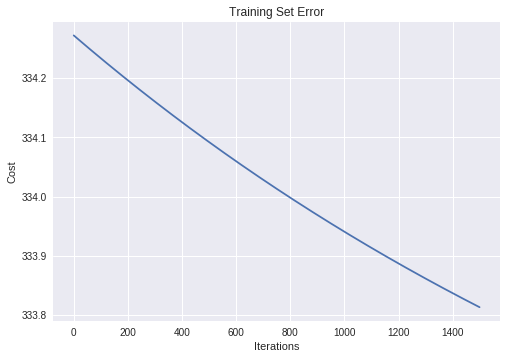

The train set MSE is: 333.813023972801
The test set MSE is: 35.651921021001044


In [24]:
evaluate_model(train_costs,parameters,X_train, Y_train, X_test, Y_test)

## Summary and Extensions:

You've just trained your first deep learning model! As an extension, try running the code again, but this time, use the **load_cancer()** function instead of **load boston()**. This is a dataset that classifies breast cancer as malignant/benign.

Remember that sigmoid function in the lectures? We can use it to predict probabilities for classification, so all you need to do is apply it to the output of the final layer.

A couple of other minor tweaks - for classification, the network uses the **cross-entropy loss** as a cost function instead of mean-square error, and you'll want to print out accuracy not MSE in the evaluation function. 

But the cool thing is that the network structure is the **same**! The same network, just with a sigmoid function applied to the output, can be trained on a *completely different task* and still work.

That's the power of deep learning! Stay tuned for future workshops on specialised deep learning models for computer vision and natural language processing. If you want to dive deeper, head over to the [blog](http://mukul-rathi.github.io/blog.html).

In [16]:
print("Have a good day!")

Have a good day!
